In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
from scipy import integrate
import pandas as pd
from functools import partial
import models

# The FT + Confined Model

$$
\begin{aligned}
\mathbf{\dot{A}}^{FT}&=\mathbf{W}\cdot\mathbf{A}-\mathbf{A}\cdot\mathbf{W}+\xi(\mathbf{D}\cdot\mathbf{A}+\mathbf A\cdot\mathbf D-2\mathbb{A}_4:\mathbf D)+2C_I\dot\lambda(\mathbf I-3\mathbf A)\\
\mathbf{\dot{A}}^{FT+Confined}&=\mathbf{\dot{A}}^{FT}+|\dot{\gamma}|(\mathbf{D^*}\cdot\mathbf{A}+\mathbf A\cdot\mathbf D^*-2\mathbb{A}_4:\mathbf D^*)\\
where\quad \mathbf{D^*}&=\epsilon\begin{pmatrix}
                                 \frac{1}{2}+\alpha& 0 & 0\\ 
                                 0& -1 &0 \\ 
                                 0& 0 &\frac{1}{2}-\alpha 
                                \end{pmatrix}\\
and \quad \alpha&\subseteq[-0.5,0.5]
\end{aligned}
$$

In [2]:
def da2_FT_Confined_model(a2,L,CI,rho,confined_epsilon,alpha,a4_method='IBOF'):
    '''a2: the orientation tensor
    rho: the aspect ratio of the fiber
    L: the velocity gradient tensor
    CI: the interaction coefficient
    confined_epsilon, alpha: confined term paramter
    a4_method: 'IBOF', 'ORW3'
    '''
    I=np.eye(3)
    D=0.5*(L+L.T)
    D_star=np.array([[0.5+alpha,0,0], \
                    [0, -1, 0], \
                    [0, 0, 0.5-alpha]])
    W=0.5*(L-L.T)
    if a4_method=='IBOF':
        a4=models.a4_IBOF.a4_IBOF(a2)
    elif a4_method=='ORW3':
        a4=models.a4_ORW3.a4_ORW3(a2)
    shear_rate=np.sqrt(np.tensordot(D,D,axes=([0,1],[1,0]))*2)
    da2=np.dot(W,a2)-np.dot(a2,W)+ \
            (rho**2-1)/(rho**2+1)*(np.dot(D,a2)+np.dot(a2,D)-2*np.tensordot(a4,D,axes=([2,3],[1,0])))+ \
            2*CI*shear_rate*(I-3*a2)+ \
            confined_epsilon*(np.dot(D_star,a2)+np.dot(a2,D_star)-2*np.tensordot(a4,D_star,axes=([2,3],[1,0])))
    return da2
def da2_fun_for_ode(t,a2,CI,L,rho,confined_epsilon,alpha=0,a4_method='IBOF'):
    '''
    function for ode calculation
    a2 is the array with the shape like (9,)
    t is unused in this function
    rho: aspect ratio
    a2: 2 dimensional orientation tensor
    CI: interaction paramter,0.005<CI<0.05
    a4_method: 'IBOF', 'ORW3'
    confined_epsilon,alpha: confined term parameters

    return: array with the shape of(9,)
    '''
    a2=a2.reshape((3,3))
    a2=(a2.T+a2)/2
    da2=da2_FT_Confined_model(a2,L,CI,rho,confined_epsilon,alpha,a4_method)
    return da2.reshape((-1,))

# Demo of the FT+Confined Model 
$\mathbf{A}(t)$

<Axes: title={'center': 'simple shear of the Confined Model,epsilon=0.20'}, xlabel='time(s)'>

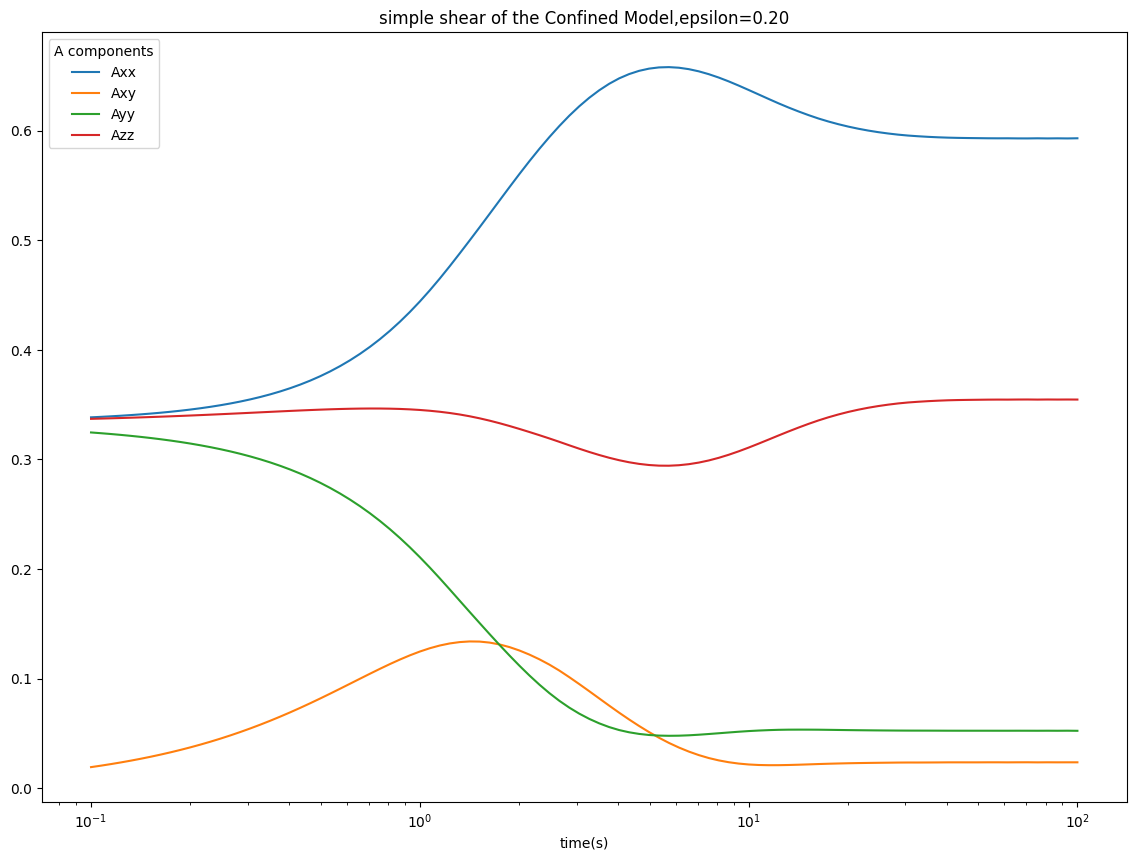

In [3]:
#######################################################
#weight concentration
wt_phi = 0.5
#volume concentration
phi=wt_phi/2.7/(1-wt_phi+wt_phi/2.7)
#aspect ratio
rho=11.8
#interaction coefficient in FT model
CI=0.03*(1-np.exp(-0.224*rho*phi))
#parameters in confined term 
confined_epsilon=0.2
alpha=0
#simple shear
L=np.zeros((3,3),dtype=np.float64)
L[0,1]=1
#for simple shear, initial state is random oriented
a2_0=np.eye(3)/3
########################################################
fun=partial(da2_fun_for_ode,CI=CI,L=L,rho=rho,confined_epsilon=confined_epsilon,alpha=alpha,a4_method='ORW3')
t_span=(0,100)
t_eval=np.logspace(-1,np.log10(t_span[1]),num=100)
res=integrate.solve_ivp(fun,t_span,a2_0.reshape((-1,)),method='RK45',t_eval=t_eval)
res_df=pd.DataFrame(res.y.T,index=res.t,columns=['Axx','Axy','Axz',\
                                                'Ayx','Ayy','Ayz',\
                                                'Azx','Azy','Azz'])
res_df.index.name='time(s)'
res_df.columns.name='A components'
res_df.plot(y=['Axx','Axy','Ayy','Azz'],\
            title="simple shear of the Confined Model,epsilon=%.2f" %confined_epsilon,\
            figsize=(14,10),logx=True)

# Influence of parameters $\epsilon$ and $\alpha$

CPU times: user 1min 10s, sys: 6.81 s, total: 1min 17s
Wall time: 53.2 s


<Axes: title={'center': 'Azz value'}, xlabel='alpha'>

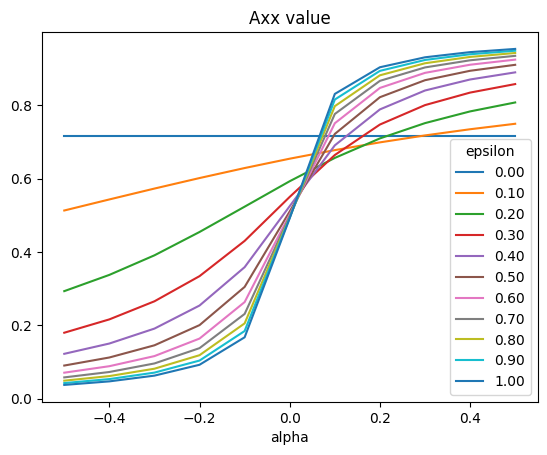

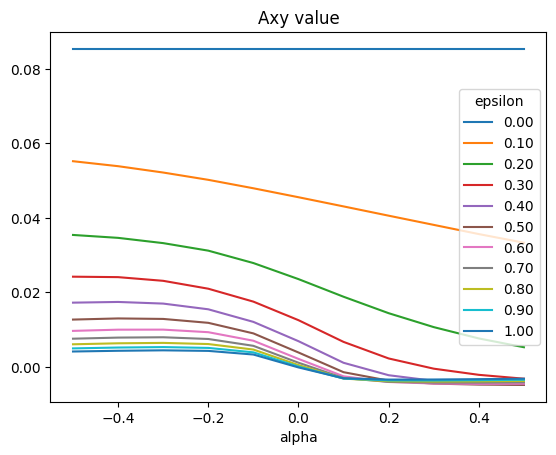

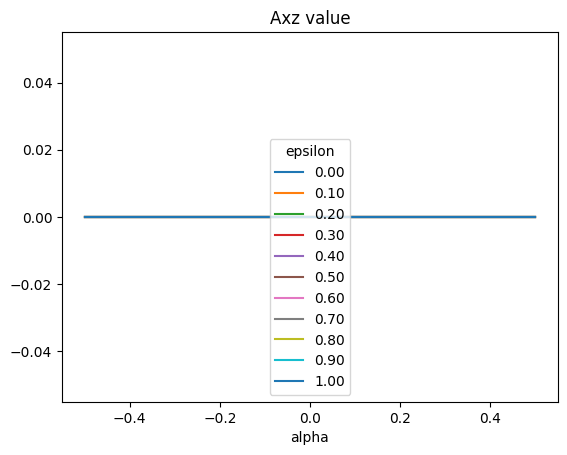

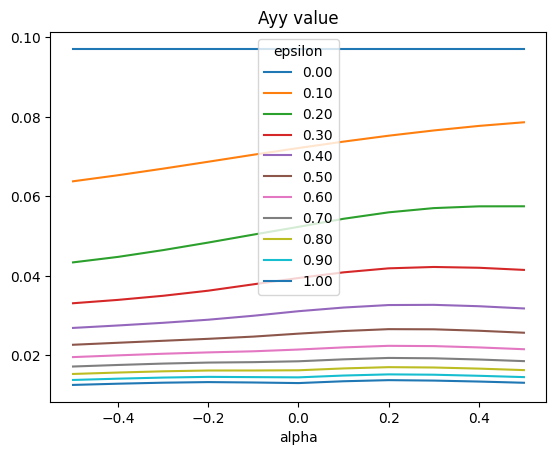

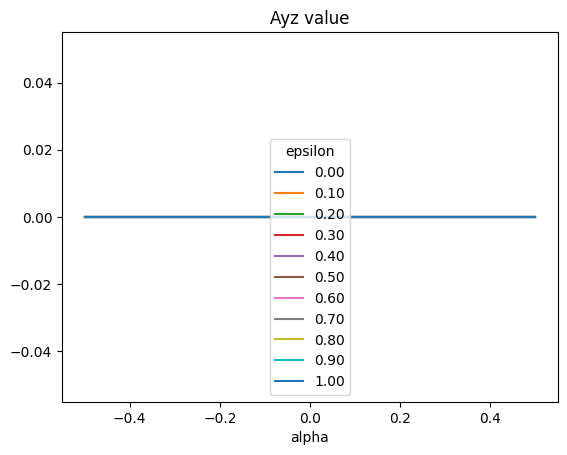

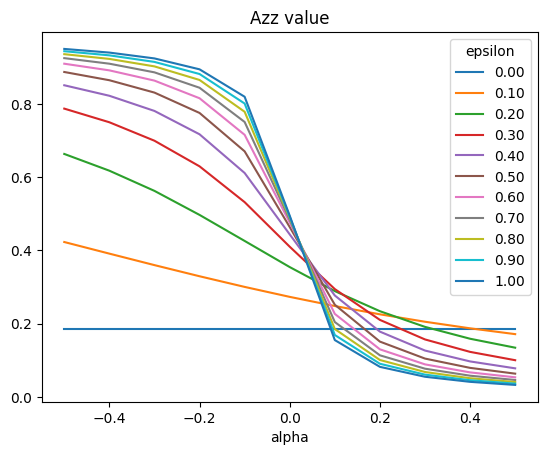

In [5]:
%%time
#######################################
#parameters
wt_phi = 0.5
phi=wt_phi/2.7/(1-wt_phi+wt_phi/2.7)
rho=11.8
CI=0.03*(1-np.exp(-0.224*rho*phi))
#initial state is random oriented
a2_0=np.eye(3)/3
#simple shear
shear_rate=1
L=np.zeros((3,3),dtype=np.float64)
L[0,1]=shear_rate
########################################
#Dataframes to store the results
steady_axx_df=pd.DataFrame()
steady_axx_df.index.name="alpha"
steady_axx_df.columns.name="epsilon"
steady_axy_df=steady_axx_df.copy()
steady_axz_df=steady_axx_df.copy()
steady_ayy_df=steady_axx_df.copy()
steady_ayz_df=steady_axx_df.copy()
steady_azz_df=steady_axx_df.copy()
#change epsilon and alpha
for alpha in np.linspace(-0.5,0.5,11):
    for confined_epsilon in np.linspace(0,1,11):
        fun=partial(da2_fun_for_ode, CI = CI, L = L, rho = rho, confined_epsilon = confined_epsilon, alpha = alpha , a4_method = 'ORW3')
        t_span=(0,100)
        t_eval=np.logspace(-1,np.log10(t_span[1]),num=100)
        res=integrate.solve_ivp(fun,t_span,a2_0.reshape((-1,)),method='RK45',t_eval=t_eval)
        res_df=pd.DataFrame(res.y.T,index=res.t)
        res_df.index.name='time(s)'
        #res_df.to_csv("csv/alpha_{:0.2f}_epsilon_{:0.2f}.csv".format(alpha,confined_epsilon))
        steady_axx_df.loc[alpha,"{:.2f}".format(confined_epsilon)]=res_df.iloc[-1,0]
        steady_axy_df.loc[alpha,"{:.2f}".format(confined_epsilon)]=res_df.iloc[-1,1]
        steady_axz_df.loc[alpha,"{:.2f}".format(confined_epsilon)]=res_df.iloc[-1,2]
        steady_ayy_df.loc[alpha,"{:.2f}".format(confined_epsilon)]=res_df.iloc[-1,4]
        steady_ayz_df.loc[alpha,"{:.2f}".format(confined_epsilon)]=res_df.iloc[-1,5]
        steady_azz_df.loc[alpha,"{:.2f}".format(confined_epsilon)]=res_df.iloc[-1,8]

#plot the results
steady_axx_df.plot(title="Axx value")
steady_axy_df.plot(title="Axy value")
steady_axz_df.plot(title="Axz value")
steady_ayy_df.plot(title="Ayy value")
steady_ayz_df.plot(title="Ayz value")
steady_azz_df.plot(title="Azz value")